In [1]:
import pandas as pd
import seaborn as sns
#%matplotlib widget

In [2]:
df = pd.read_csv('out.csv')
df = df.rename(columns={'mode': 'mode_str', 'sum': 'sum_result'})
df['multithreaded'] = df.nb_threads > 0
speedup = df[df.mode_str=='naive'].set_index(['n', 'nb_threads', 'trial']).time_ms / df.set_index(['n', 'nb_threads', 'mode_str', 'trial']).time_ms
speedup = speedup.reset_index().rename(columns={'time_ms': 'speedup'})
error = ((df[df.mode_str=='oracle'].set_index(['n']).sum_result - df.set_index(['n', 'nb_threads', 'mode_str', 'trial']).sum_result).abs() / 
            df[df.mode_str=='oracle'].set_index(['n']).sum_result)
error = error.reset_index().rename(columns={'sum_result': 'error_relative'})
df = pd.merge(df, speedup, on=['n', 'nb_threads', 'trial', 'mode_str'])
df = pd.merge(df, error, on=['n', 'nb_threads', 'trial', 'mode_str'])

palette = dict(zip(df.mode_str.unique(), sns.color_palette(n_colors=len(df.mode_str.unique()))))
df

,n,nb_threads,mode_str,trial,sum_result,time_ms,multithreaded,speedup,error_relative
0,256,-1,oracle,0,1.690439e+02,0.000000,False,inf,0.000000e+00
1,256,-1,double,0,1.690439e+02,0.003174,False,0.923125,1.183125e-08
2,256,-1,double,1,1.690439e+02,0.004150,False,0.706024,1.183125e-08
3,256,-1,double,2,1.690439e+02,0.003174,False,0.923125,1.183125e-08
4,256,-1,double,3,1.690439e+02,0.002930,False,1.333106,1.183125e-08
...,...,...,...,...,...,...,...,...,...
916,25600000,-1,pytorch,0,1.706544e+07,44.984579,False,1.104844,1.580277e-11
917,25600000,-1,pytorch,1,1.706544e+07,43.978930,False,1.127970,1.580277e-11
918,25600000,-1,pytorch,2,1.706544e+07,44.162989,False,1.122661,1.580277e-11
919,25600000,-1,pytorch,3,1.706544e+07,43.550253,False,1.138457,1.580277e-11


# Figures for the report

The objective of this project is to compute following function :

$$
d(U) = \sum_{i=0}^{n-1} \sqrt{|u_i|}
$$

With $U$ a vector of random numbers s.t. $|u_i| < 1$.

We implemented several approaches in C:
- **naive** : naive `for` loop, using only floats
- **double** : same logic than *naive*, but using a double variable for the sum. This approach allows much better precision
- **rec** : a recursive approach we tried, to get a precise sum using only floats. This significantly improved the precision compared to *naive*, but is slower to compute. Another equivalent but faster function (similar to *naive*) could also have been implemented with a bottom-up logic.
- **vec** : a vectorized version of *naive*, using AVX and `__m256` variables

We also implemented the same norm function in python, for comparison:
- **python** : equivalent of the naive `for` loop, but in pure python
- **numpy** : computing the result using the widely used `numpy` numerical computing library, with a number of operations actually implemented in C
- **pytorch** : idem, with the machine learning framework `pytorch`

We ran a couple experiments on Debian machines with the following specs :
```
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
Address sizes:       39 bits physical, 48 bits virtual
CPU(s):              12
On-line CPU(s) list: 0-11
Thread(s) per core:  2
Core(s) per socket:  6
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               158
Model name:          Intel(R) Core(TM) i7-8700K CPU @ 3.70GHz
Stepping:            10
CPU MHz:             800.567
CPU max MHz:         4700.0000
CPU min MHz:         800.0000
BogoMIPS:            7392.00
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            12288K
NUMA node0 CPU(s):   0-11
```

Our program was compiled **with no optimization flags**, using gcc 8.3.0 and the following command: `gcc -o project project.c -mavx -lpthread -lm -Wall`

## Without multithreading
We run a couple experiments to compare the various implementations, with different values for `n`, the size of the vector.

We can observe that:
- The *naive* and *double* versions consistently take the same amount of time. This actually makes sense as we are using a x86 architecture which implements doubles and emulates float, the float operations should not be faster. (The precision and correctness of the result does change drastically for large `n` though)
- The vectorized version *vec* is significantly faster than the *naive* version (3.3 times faster without multithreading). As a single `__m256` operation operates on 8 floats at the same time, we could have expected up to a 8x speedup, but this seems to be due to the `sqrt` function that `_mm256_sqrt_ps` uses. When using the more precise `sqrt` function in the *naive* approach as well (instead of `sqrtf`), the *naive* approach was actually almost exactly 8x longer to execute.
- Interestingly, the *numpy* and *pytorch* approaches are orders of magnitude faster than the naive *python* approach, but are not faster than the *naive* C approach (without even setting optimization flags).

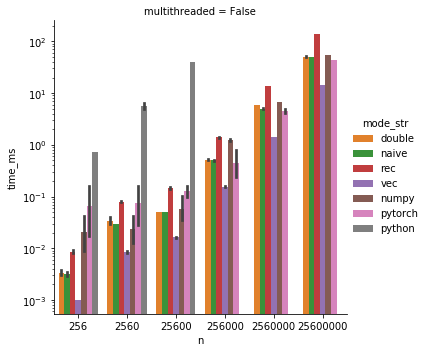

In [3]:
g = sns.catplot(x='n', y='time_ms', hue='mode_str', col='multithreaded', kind='bar', sharey=False,
                data=df[(df.mode_str != 'oracle') & (df.nb_threads==-1)], palette=palette)
g.set(yscale='log')

In [4]:
df[df.mode_str.isin(['vec', 'numpy'])].groupby(['mode_str', 'nb_threads']).speedup.mean()

mode_str  nb_threads
numpy     -1            0.871745
vec       -1            3.299917
           1            2.161675
           2            2.513281
           4            1.971108
           8            1.634851
           16           1.559915
           32           1.553804
Name: speedup, dtype: float64

## Using `pthread` to parallelize the computations

We also ran experiments with various values for `nb_threads` :
- with `nb_threads = -1`, there is no threads, just like before
- for `nb_threads > 0`, we parallelize the computation using this number of threads

We observe that creating and using the threads adds an overhead that can be quite significant when `n` is small (an order of magnitude or more). However, as expected, multi-threading does speed up the program for larger values of `n`.

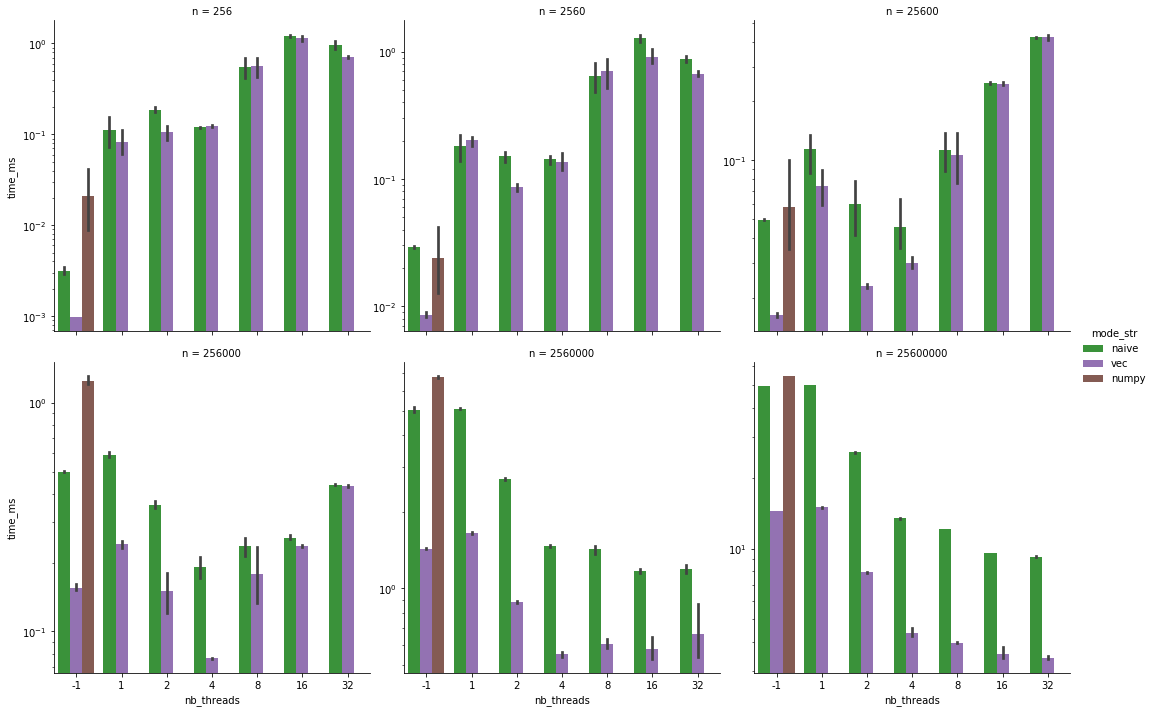

In [5]:
g = sns.catplot(x='nb_threads', y='time_ms', hue='mode_str', col='n', kind='bar', col_wrap=3, sharey=False, 
                data=df[df.mode_str.isin(['numpy', 'naive', 'vec'])], palette=palette)
g.set(yscale='log')

## Remarks on the precision

In order to get a better insight on the numerical error, we compared our results with the results of an *oracle* function working and returning double precision. The figure below shows the mean relative error (across trials), compared to the *oracle*.

As could be expected, when using float variables to store the sum of our computations so far (like in the **naive** and **vec** approaches), the error grows when `n` gets larger. When `n` gets large, the `sum` variable gets large as well at some point, in which case we lose more and more precision when adding small numbers (recall that $|u_i| < 1$). For very large values of `n` (not shown here), there is even a point where adding $u_i$ to the `sum` variable does nothing at all, which leads to completely incorrect results.

This issue can be prevented using double variables to store the sum (like in the **double** approach), in which case we don't lose precision when adding the $u_i$. This could also be implemented in a vectorized way, using `__m256d` variables that store 4 doubles instead of 8 floats. However, in this case switching to double precision would probably slow down the computations, as twice less operations would be done at the same time.

Finally, our recursive approach **rec** using only float variables does fix the precision issue, and is similar to the **double** approach. Instead of summing the small $u_i$ to a single `sum` variable that keeps getting larger, the recursive approach sums the $u_i$ between them progressively in order to always add numbers of the same order of magnitude.

In [6]:
df.error_relative.describe()

count    9.210000e+02
mean     3.624284e-04
std      2.369548e-03
min      0.000000e+00
25%      1.183125e-08
50%      5.962132e-08
75%      1.591804e-07
max      2.133949e-02
Name: error_relative, dtype: float64

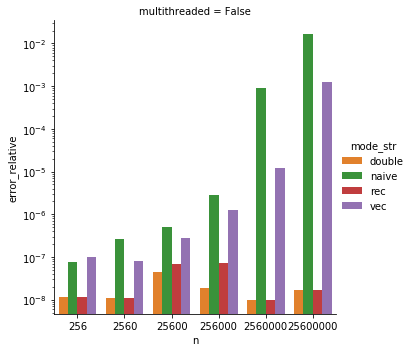

In [7]:
g = sns.catplot(x='n', y='error_relative', hue='mode_str', col='multithreaded', kind='bar', sharey=False, 
                data=df[df.mode_str.isin(['naive', 'double', 'rec', 'vec']) & (df.nb_threads < 0)], palette=palette)
g.set(yscale='log')

# Other additional figures

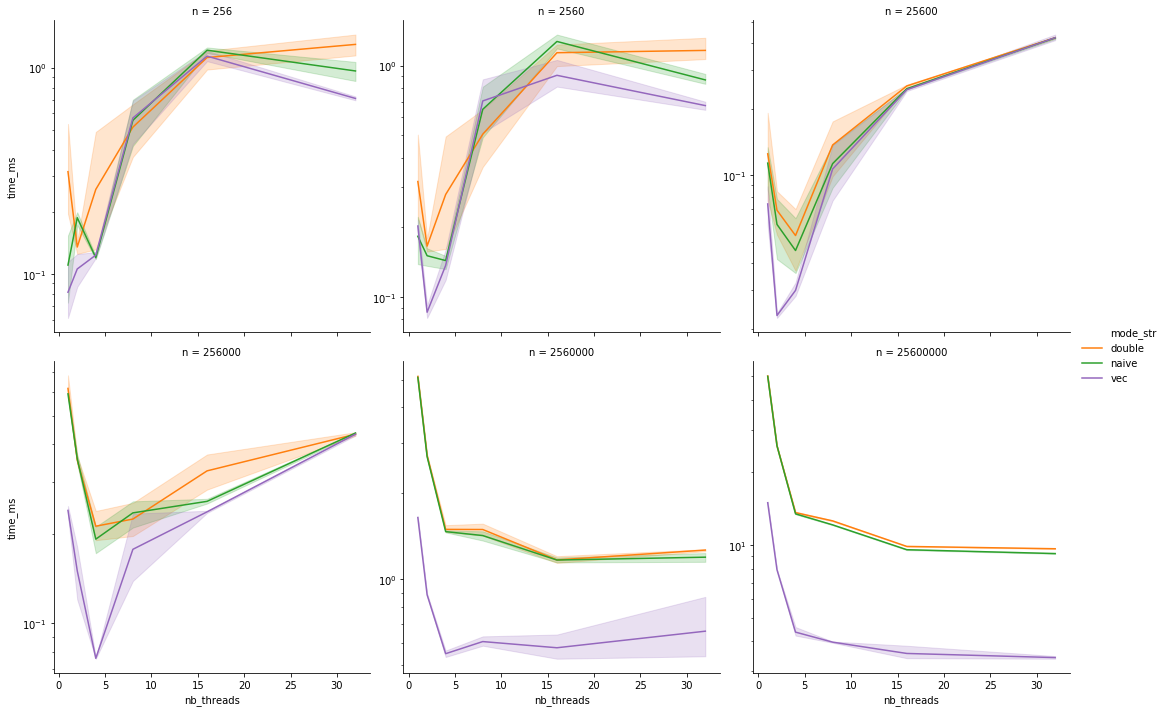

In [8]:
g = sns.relplot(x='nb_threads', y='time_ms', hue='mode_str', col='n', kind='line', col_wrap=3, markers=True, facet_kws={'sharey':False}, 
                data=df[df.mode_str.isin(['naive', 'double', 'vec']) & (df.multithreaded)], palette=palette)
g.set(yscale='log')